In [1]:
!nvidia-smi

Wed Jul  8 01:34:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive

drive.mount('./gdrive', force_remount=True)
%cd './gdrive/My Drive/cubricks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive
/content/gdrive/My Drive/cubricks


In [3]:
!pip install -q tensorflow-gpu

     |████████████████████████████████| 516.2MB 29kB/s 


In [4]:
%tensorflow_version 2.x

import os
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
### Load csv file ###
df = pd.read_csv('InvoicedDocuments_v2.csv', na_values=['N/I'])

### Trim string/Remove duplicates ###
df.columns = df.columns.str.replace(' ', '')
df.drop_duplicates('Document', keep=False, inplace=True)

### String to datetime format ###
df['DocumentDate'] = pd.to_datetime(df['DocumentDate'], errors='coerce')
df['DueDate'] = pd.to_datetime(df['DueDate'], errors='coerce')
df['ClearingDate'] = pd.to_datetime(df['ClearingDate'], errors='coerce')
df['LastCreditReview'] = pd.to_datetime(df['LastCreditReview'], errors='coerce')

### Drop/Fill null values ###
df.dropna(subset=['DocumentDate', 'Document', 'DueDate', 'ClearingDate'], inplace=True)
df[df.columns.drop('LastCreditReview')].fillna(0, inplace=True)

### Float to integer ###
df['Company'] = pd.to_numeric(df['Company'], downcast='integer')
df['Document'] = pd.to_numeric(df['Document'], downcast='integer')
df['CustomerCode'] = pd.to_numeric(df['CustomerCode'], downcast='integer')

### String to number ###
string_number = lambda x: int(''.join(format(ord(w), '') for w in str(x)))
df['Country'] = df['Country'].apply(string_number)
df['Region'] = df['Region'].apply(string_number)
df['Terms'] = df['Terms'].apply(string_number)

### Amount treatment/filter ###
df['Amount'] = df['Amount'].apply(lambda x: int(str(x).replace(',', '')))
df = df[df['Amount'] > 20]

### Summary ###
df.info()
df.head(100)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1922155 entries, 1 to 1973661
Data columns (total 11 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Company           int16         
 1   CustomerCode      int32         
 2   Country           int64         
 3   Region            int64         
 4   LastCreditReview  datetime64[ns]
 5   DocumentDate      datetime64[ns]
 6   Document          int32         
 7   DueDate           datetime64[ns]
 8   ClearingDate      datetime64[ns]
 9   Terms             int64         
 10  Amount            int64         
dtypes: datetime64[ns](4), int16(1), int32(2), int64(4)
memory usage: 150.3 MB


,Company,CustomerCode,Country,Region,LastCreditReview,DocumentDate,Document,DueDate,ClearingDate,Terms,Amount
1,15,306047,8583,7589,2017-11-17,2018-10-22,928300874,2018-11-14,2018-11-06,785049,665
2,15,306047,8583,7589,2017-11-17,2019-03-09,929206156,2019-04-01,2019-03-28,785049,665
3,4005,400250,8583,8765,2017-12-19,2019-08-20,930280762,2019-08-30,2019-09-03,74827971,84166
4,8040,395434,6765,6566,NaT,2018-12-21,928703204,2019-01-02,2018-12-28,74784855,522
5,15,306047,8583,7589,2017-11-17,2018-08-25,927902426,2018-09-17,2018-09-12,785049,522
...,...,...,...,...,...,...,...,...,...,...,...
97,3025,389450,8583,7365,NaT,2019-12-10,931049793,2019-12-31,2020-01-07,785049,1393
98,3025,380565,8583,7376,2017-12-19,2019-09-30,930553253,2019-10-12,2019-10-15,74784855,40779
99,72,302456,8583,7778,2018-09-21,2019-12-06,931023530,2019-12-21,2019-12-18,784952,5351
100,1,400250,8583,8765,2017-12-19,2019-08-02,930159140,2019-08-14,2019-08-15,78494868,3672


In [6]:
#########################
### Generate DaysTo__ ###
#########################
df['DaysToLastCreditReview'] = df['DocumentDate'] - df['LastCreditReview']
df['DaysToLastCreditReview'] = df['DaysToLastCreditReview'].fillna(pd.Timedelta(seconds=-1)).astype('timedelta64[D]').astype(int)
df = df[df['DaysToLastCreditReview'] >= -1]

df['DaysToDue'] = (df['DueDate'] - df['DocumentDate']).astype('timedelta64[D]').astype(int)
df = df[df['DaysToDue'] > 0]

df['DaysToClearingDate'] = (df['ClearingDate'] - df['DocumentDate']).astype('timedelta64[D]').astype(int)
df = df[df['DaysToClearingDate'] > 0]

df.head(10)

,Company,CustomerCode,Country,Region,LastCreditReview,DocumentDate,Document,DueDate,ClearingDate,Terms,Amount,DaysToLastCreditReview,DaysToDue,DaysToClearingDate
1,15,306047,8583,7589,2017-11-17,2018-10-22,928300874,2018-11-14,2018-11-06,785049,665,339,23,15
2,15,306047,8583,7589,2017-11-17,2019-03-09,929206156,2019-04-01,2019-03-28,785049,665,477,23,19
3,4005,400250,8583,8765,2017-12-19,2019-08-20,930280762,2019-08-30,2019-09-03,74827971,84166,609,10,14
4,8040,395434,6765,6566,NaT,2018-12-21,928703204,2019-01-02,2018-12-28,74784855,522,-1,12,7
5,15,306047,8583,7589,2017-11-17,2018-08-25,927902426,2018-09-17,2018-09-12,785049,522,281,23,18
6,15,306047,8583,7589,2017-11-17,2019-05-01,929535612,2019-05-23,2019-05-21,785049,522,530,22,20
7,15,306047,8583,7589,2017-11-17,2019-03-25,929311550,2019-04-17,2019-04-09,785049,522,493,23,15
8,15,306047,8583,7589,2017-11-17,2019-07-27,930121446,2019-08-17,2019-08-13,785049,522,617,21,17
9,15,306047,8583,7589,2017-11-17,2019-09-21,930502555,2019-10-12,2019-10-16,785049,522,673,21,25
10,1,380619,8583,7867,2017-10-17,2019-02-14,929046662,2019-02-26,2019-02-27,74784855,31492,485,12,13


,Company,CustomerCode,Country,Region,LastCreditReview,DocumentDate,Document,DueDate,ClearingDate,Terms,Amount,DaysToLastCreditReview,DaysToDue,DaysToClearingDate,IsLate
1,15,306047,8583,7589,2017-11-17,2018-10-22,928300874,2018-11-14,2018-11-06,785049,665,339,23,15,0
2,15,306047,8583,7589,2017-11-17,2019-03-09,929206156,2019-04-01,2019-03-28,785049,665,477,23,19,0
3,4005,400250,8583,8765,2017-12-19,2019-08-20,930280762,2019-08-30,2019-09-03,74827971,84166,609,10,14,1
4,8040,395434,6765,6566,NaT,2018-12-21,928703204,2019-01-02,2018-12-28,74784855,522,-1,12,7,0
5,15,306047,8583,7589,2017-11-17,2018-08-25,927902426,2018-09-17,2018-09-12,785049,522,281,23,18,0
6,15,306047,8583,7589,2017-11-17,2019-05-01,929535612,2019-05-23,2019-05-21,785049,522,530,22,20,0
7,15,306047,8583,7589,2017-11-17,2019-03-25,929311550,2019-04-17,2019-04-09,785049,522,493,23,15,0
8,15,306047,8583,7589,2017-11-17,2019-07-27,930121446,2019-08-17,2019-08-13,785049,522,617,21,17,0
9,15,306047,8583,7589,2017-11-17,2019-09-21,930502555,2019-10-12,2019-10-16,785049,522,673,21,25,1
10,1,380619,8583,7867,2017-10-17,2019-02-14,929046662,2019-02-26,2019-02-27,74784855,31492,485,12,13,1


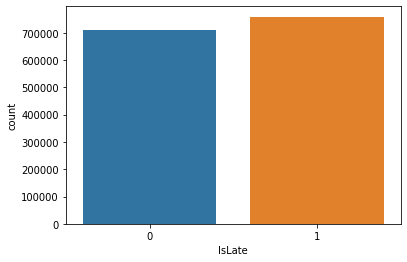

In [7]:
#####################
### Define IsLate ###
#####################
df['IsLate'] = (df['DueDate'] - df['ClearingDate']).astype('timedelta64[D]').astype(int)
df['IsLate'] = df['IsLate'].apply(lambda x: 0 if x > 0 else 1)

sns.countplot(df['IsLate'])
df.head(10)

Labels: ['1-7', '8-14', '15-21', '22-28', '29-inf']


,Company,CustomerCode,Country,Region,LastCreditReview,DocumentDate,Document,DueDate,ClearingDate,Terms,Amount,DaysToLastCreditReview,DaysToDue,DaysToClearingDate,IsLate,ClearingDateRange,ClearingDateRangeCT
1,15,306047,8583,7589,2017-11-17,2018-10-22,928300874,2018-11-14,2018-11-06,785049,665,339,23,15,0,15-21,2
2,15,306047,8583,7589,2017-11-17,2019-03-09,929206156,2019-04-01,2019-03-28,785049,665,477,23,19,0,15-21,2
3,4005,400250,8583,8765,2017-12-19,2019-08-20,930280762,2019-08-30,2019-09-03,74827971,84166,609,10,14,1,8-14,1
4,8040,395434,6765,6566,NaT,2018-12-21,928703204,2019-01-02,2018-12-28,74784855,522,-1,12,7,0,1-7,0
5,15,306047,8583,7589,2017-11-17,2018-08-25,927902426,2018-09-17,2018-09-12,785049,522,281,23,18,0,15-21,2
6,15,306047,8583,7589,2017-11-17,2019-05-01,929535612,2019-05-23,2019-05-21,785049,522,530,22,20,0,15-21,2
7,15,306047,8583,7589,2017-11-17,2019-03-25,929311550,2019-04-17,2019-04-09,785049,522,493,23,15,0,15-21,2
8,15,306047,8583,7589,2017-11-17,2019-07-27,930121446,2019-08-17,2019-08-13,785049,522,617,21,17,0,15-21,2
9,15,306047,8583,7589,2017-11-17,2019-09-21,930502555,2019-10-12,2019-10-16,785049,522,673,21,25,1,22-28,3
10,1,380619,8583,7867,2017-10-17,2019-02-14,929046662,2019-02-26,2019-02-27,74784855,31492,485,12,13,1,8-14,1


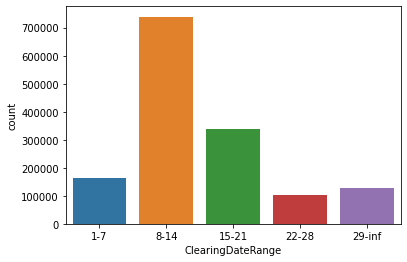

In [8]:
###############################################
### Define ClearingDateRange and Categorize ###
###############################################
bins = [1, 8, 15, 22, 29, np.inf]
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins[:-1]))]

print(f'Labels: {labels}')

df['ClearingDateRange'] = pd.cut(df['DaysToClearingDate'], bins=bins, labels=labels, right=False, include_lowest=True)
df[['ClearingDateRangeCT']] = df[['ClearingDateRange']].apply(lambda x: pd.Categorical(x, ordered=True).codes)

sns.countplot(df['ClearingDateRange'])
df.head(10)

,Company,CustomerCode,Country,Region,LastCreditReview,DocumentDate,Document,DueDate,ClearingDate,Terms,Amount,DaysToLastCreditReview,DaysToDue,DaysToClearingDate,IsLate,ClearingDateRange,ClearingDateRangeCT,DocumentMonth,DocumentDay,DocumentWeekDay
1,15,306047,8583,7589,2017-11-17,2018-10-22,928300874,2018-11-14,2018-11-06,785049,665,339,23,15,0,15-21,2,10,22,0
2,15,306047,8583,7589,2017-11-17,2019-03-09,929206156,2019-04-01,2019-03-28,785049,665,477,23,19,0,15-21,2,3,9,5
3,4005,400250,8583,8765,2017-12-19,2019-08-20,930280762,2019-08-30,2019-09-03,74827971,84166,609,10,14,1,8-14,1,8,20,1
4,8040,395434,6765,6566,NaT,2018-12-21,928703204,2019-01-02,2018-12-28,74784855,522,-1,12,7,0,1-7,0,12,21,4
5,15,306047,8583,7589,2017-11-17,2018-08-25,927902426,2018-09-17,2018-09-12,785049,522,281,23,18,0,15-21,2,8,25,5
6,15,306047,8583,7589,2017-11-17,2019-05-01,929535612,2019-05-23,2019-05-21,785049,522,530,22,20,0,15-21,2,5,1,2
7,15,306047,8583,7589,2017-11-17,2019-03-25,929311550,2019-04-17,2019-04-09,785049,522,493,23,15,0,15-21,2,3,25,0
8,15,306047,8583,7589,2017-11-17,2019-07-27,930121446,2019-08-17,2019-08-13,785049,522,617,21,17,0,15-21,2,7,27,5
9,15,306047,8583,7589,2017-11-17,2019-09-21,930502555,2019-10-12,2019-10-16,785049,522,673,21,25,1,22-28,3,9,21,5
10,1,380619,8583,7867,2017-10-17,2019-02-14,929046662,2019-02-26,2019-02-27,74784855,31492,485,12,13,1,8-14,1,2,14,3


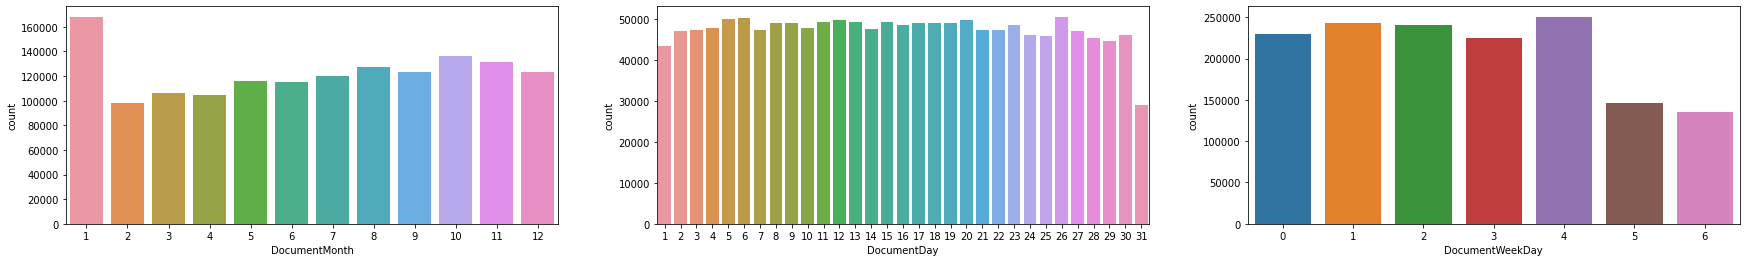

In [9]:
################################################
### Extract Document/Due month, day, weekday ###
################################################
df['DocumentMonth'] = df['DocumentDate'].dt.month
df['DocumentDay'] = df['DocumentDate'].dt.day
df['DocumentWeekDay'] = df['DocumentDate'].dt.weekday


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,4))
sns.countplot(df['DocumentMonth'], ax=ax[0])
sns.countplot(df['DocumentDay'], ax=ax[1])
sns.countplot(df['DocumentWeekDay'], ax=ax[2])

df.head(10)

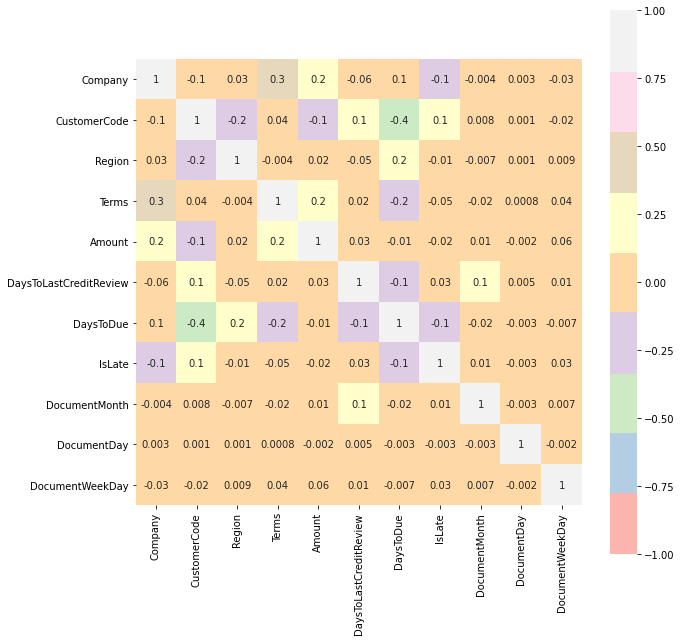

In [10]:
y_column = np.array(['ClearingDateRangeCT'])
features = np.array([
                    #  'ClearingDateRangeCT',
                    #  'DaysToClearingDate',
                    #  'Document',
                     'Company',
                     'CustomerCode',
                    #  'Country',
                     'Region',
                     'Terms',
                     'Amount',
                     'DaysToLastCreditReview',
                     'DaysToDue',
                     'IsLate',
                     'DocumentMonth',
                     'DocumentDay',
                     'DocumentWeekDay',
                     ])


plt.figure(figsize=(10, 10))
sns.heatmap(df[features].corr(), square=True, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='Pastel1')

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df[features].values,
                                                    df[y_column].values,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=df[y_column].values)

In [12]:
# dumb predict
print(f'Total items: {len(y_test)}')

for i in range(len(labels)):
    dumb_data = np.ones(y_test.shape, dtype=np.int) * i
    print(f'Always predicting the range "{i}",', f'accuracy is {accuracy_score(y_test, dumb_data) * 100:.2f}%')

Total items: 147041
Always predicting the range "0", accuracy is 11.11%
Always predicting the range "1", accuracy is 50.26%
Always predicting the range "2", accuracy is 22.89%
Always predicting the range "3", accuracy is 7.06%
Always predicting the range "4", accuracy is 8.68%


In [13]:
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42, n_jobs=-1)
random_forest.fit(x_train, np.squeeze(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Total items: 147041
Accuracy: 88.03%

Feature ranking:
0.19568247383527104	DaysToDue
0.1429987108377586	Amount
0.10902792790246729	CustomerCode
0.09144573138684953	DaysToLastCreditReview
0.09056533780023601	Terms
0.07689451881330166	IsLate
0.07563376543984442	DocumentDay
0.06400310638363314	Region
0.057800793897466826	DocumentWeekDay
0.05152243620457289	DocumentMonth
0.04442519749859878	Company


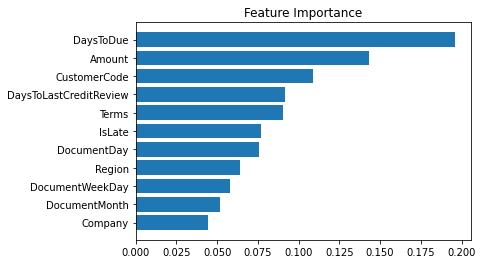

In [14]:
predict = random_forest.predict(x_test)

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]

print(f'Total items: {len(y_test)}')
print(f'Accuracy: {accuracy_score(y_test, predict) * 100:.2f}%\n')
print(f'Feature ranking:')

for f in range(x_train.shape[1]):
    print(f'{importances[indices[f]]}\t{features[indices[f]]}')

plt.barh(range(x_train.shape[1]), importances[indices])
plt.yticks(range(x_train.shape[1]), features[indices])
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [15]:
cm_report = classification_report(y_test, predict, target_names=labels)
print(cm_report)

              precision    recall  f1-score   support

         1-7       0.86      0.81      0.84     16336
        8-14       0.90      0.93      0.91     73901
       15-21       0.85      0.84      0.85     33664
       22-28       0.81      0.74      0.77     10375
      29-inf       0.92      0.88      0.90     12765

    accuracy                           0.88    147041
   macro avg       0.87      0.84      0.86    147041
weighted avg       0.88      0.88      0.88    147041



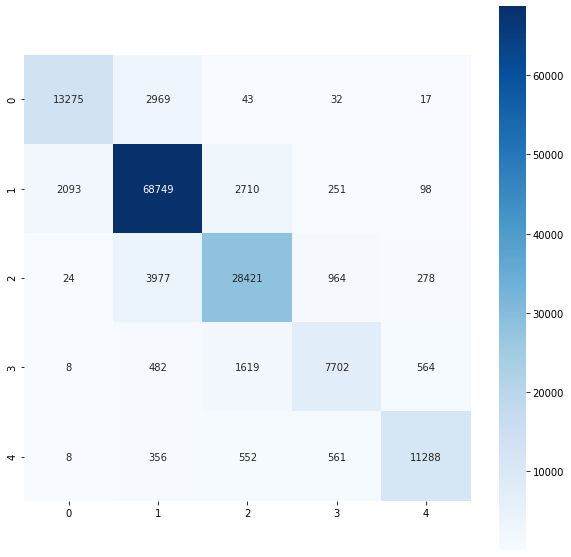

In [16]:
cm = confusion_matrix(y_test, predict)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cmap='Blues')

In [17]:
def binary_encoding(df, columns, left_padding=0):
  for item in columns:
    col = np.array([str('{0:b}'.format(x)) for x in df[item].values])
    maxlength = len(max(col, key=len)) + left_padding

    header = np.array([f'{item}{i}' for i in range(maxlength)])
    newcol = np.zeros((col.shape[0], maxlength), dtype=np.int8)

    for i in range(len(col)):
      a = np.array(list(col[i]), dtype=np.int8)
      newcol[i][maxlength - len(a):] = a

    df2 = pd.DataFrame(newcol, columns=header)

    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, df2], axis=1)

  df.drop(columns=columns, inplace=True)
  return df


df_network = df[features].copy()

category = ['Company',
            'CustomerCode',
            'Region',
            'Terms',
            'DocumentMonth',
            'DocumentDay',
            'DocumentWeekDay']

df_network = binary_encoding(df_network, category)

df_network.head(10)

,Amount,DaysToLastCreditReview,DaysToDue,IsLate,Company0,Company1,Company2,Company3,Company4,Company5,Company6,Company7,Company8,Company9,Company10,Company11,Company12,CustomerCode0,CustomerCode1,CustomerCode2,CustomerCode3,CustomerCode4,CustomerCode5,CustomerCode6,CustomerCode7,CustomerCode8,CustomerCode9,CustomerCode10,CustomerCode11,CustomerCode12,CustomerCode13,CustomerCode14,CustomerCode15,CustomerCode16,CustomerCode17,CustomerCode18,Region0,Region1,Region2,Region3,...,Region23,Terms0,Terms1,Terms2,Terms3,Terms4,Terms5,Terms6,Terms7,Terms8,Terms9,Terms10,Terms11,Terms12,Terms13,Terms14,Terms15,Terms16,Terms17,Terms18,Terms19,Terms20,Terms21,Terms22,Terms23,Terms24,Terms25,Terms26,DocumentMonth0,DocumentMonth1,DocumentMonth2,DocumentMonth3,DocumentDay0,DocumentDay1,DocumentDay2,DocumentDay3,DocumentDay4,DocumentWeekDay0,DocumentWeekDay1,DocumentWeekDay2
0,665,339,23,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,0,0
1,665,477,23,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,1,1,0,1
2,84166,609,10,1,0,1,1,1,1,1,0,1,0,0,1,0,1,1,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,1,0,0,0,0,0,...,1,1,0,0,0,1,1,1,0,1,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,1
3,522,-1,12,0,1,1,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,0,1,0,1,0,1,1,0,0
4,522,281,23,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,1,1,0,0,1,1,0,1
5,522,530,22,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0
6,522,493,23,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,1,1,1,0,0,1,0,0,0
7,522,617,21,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,1,1,1,0,1,1,1,0,1
8,522,673,21,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,1,0,1
9,31492,485,12,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,0,1,1,0,0,0,0,...,1,1,0,0,0,1,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,1,0,0,1,1


In [18]:
x_train, x_test, y_train, y_test = train_test_split(df_network.values,
                                                    df[y_column].values,
                                                    test_size=0.1, 
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=df[y_column].values)

y_train_categorical = tf.keras.utils.to_categorical(y_train)
y_test_categorical = tf.keras.utils.to_categorical(y_test)

In [19]:
def create_model():
    model = tf.keras.models.Sequential(name='cubricks')

    model.add(tf.keras.layers.Input(shape=x_train.shape[1]))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.1))

    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))
    return model


model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1, reduction='none'),
              metrics=['accuracy'])

model.summary()

Model: "cubricks"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 99)                396       
_________________________________________________________________
dense (Dense)                (None, 1024)              102400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0  

In [20]:
logdir = os.path.join('.', 'output')
os.makedirs(logdir, exist_ok=True)

training_log = os.path.join(logdir, 'training.txt')
model_checkpoint = os.path.join(logdir, 'model.hdf5')

if os.path.isfile(model_checkpoint):
    model.load_weights(model_checkpoint)

callbacks = [
    tf.keras.callbacks.TensorBoard(logdir, profile_batch=0),
    tf.keras.callbacks.CSVLogger(training_log, separator=',', append=True),
    tf.keras.callbacks.ModelCheckpoint(model_checkpoint, monitor='val_accuracy', save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', min_delta=1e-8, factor=0.2, patience=100, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-8, patience=200, restore_best_weights=True, verbose=1),
]

In [21]:
# model.fit(x_train,
#           y_train_categorical,
#           validation_data=(x_test, y_test_categorical),
#           callbacks=callbacks,
#           batch_size=1024,
#           epochs=10000,
#           verbose=1)

In [22]:
predict = np.argmax(model.predict(x_test), axis=1)

print(f'Total: {len(y_test)}')
print(f'Accuracy: {accuracy_score(y_test, predict) * 100:.2f}%')

Total: 147041
Accuracy: 88.41%


In [23]:
cm_report = classification_report(y_test, predict, target_names=labels)
print(cm_report)

              precision    recall  f1-score   support

         1-7       0.86      0.83      0.84     16336
        8-14       0.90      0.94      0.92     73901
       15-21       0.87      0.84      0.85     33664
       22-28       0.80      0.74      0.77     10375
      29-inf       0.92      0.88      0.90     12765

    accuracy                           0.88    147041
   macro avg       0.87      0.85      0.86    147041
weighted avg       0.88      0.88      0.88    147041



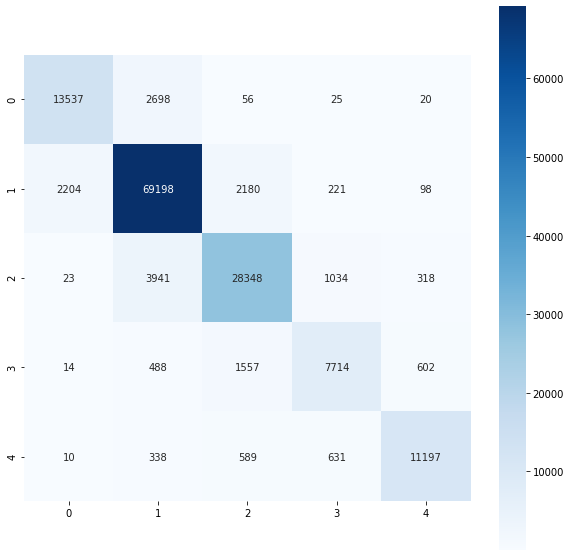

In [24]:
cm = confusion_matrix(y_test, predict)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cmap='Blues')